# Training VAE

Once data is loaded into DeepTCR, we can begin to train the variational autoencoder (VAE) which will learn the latent represnetation of the TCR sequences. This latent representation is learned from all possible inputs into DeepTCR (including alpha,beta chains, v/d/j gene usage, HLA). To train the VAE,we will first load data and then execute the Train_VAE command.

In [1]:
import sys
sys.path.append('../../')
from DeepTCR.DeepTCR import DeepTCR_U

# Instantiate training object
DTCRU = DeepTCR_U('Tutorial')

#Load Data from directories
DTCRU.Get_Data(directory='../../Data/Murine_Antigens',Load_Prev_Data=False,aggregate_by_aa=True,
               aa_column_beta=0,count_column=1,v_beta_column=2,j_beta_column=3)

Loading Data...
Embedding Sequences...
Data Loaded


In [2]:
#Train VAE
DTCRU.Train_VAE(Load_Prev_Data=False)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.Flatten instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.Dense instead.
Instructions for updating:
Use `tf.keras.layers.Conv2DTranspose` instead.
Epoch = 0, Iteration = 0 Total Loss: 7.96623: Recon Loss: 7.88468: Latent Loss: 0.08155: Sparsity Loss: 0.00000: Recon Accuracy: 0.05219
Epoch = 1, Iteration = 0 Total Loss: 7.60361: Recon Loss: 7.52287: Latent Loss: 0.08074: Sparsity Loss: 0.00000: Recon Accuracy: 0.06662
Epoch = 2, Iteration = 0 Total Loss: 7.39797: Recon Loss: 7.31709: Latent Loss: 0.08089: Sparsity Loss: 0.00000: Recon Accuracy: 0.09258
Epoch = 3, Iteration = 0 Total Loss: 7.18584: Recon Loss: 7.10360: Latent Loss: 0.08224: Sparsity Loss: 0.00000: Recon Accuracy: 0.13369
Epoch = 4, Iteration = 0 Total Loss: 7.01495: Recon Loss: 6.9

We note that during training, statistics are output to the user inclluding the various types of losses and the reconstruction accuracy of the autoencoder. If no minimum accuracy is provided, the network will train until a convergence criterion is met. Of note, we can also change the latent dimensionality by modifying the latent_dim parameter. 

In [3]:
%%capture
DTCRU.Train_VAE(Load_Prev_Data=False,accuracy_min=0.9,latent_dim=12)

INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


We can also choose to suppress the commandline output and use only sequence information or only gene-usage information as so:

In [4]:
DTCRU.Train_VAE(Load_Prev_Data=False,accuracy_min=0.9,latent_dim=12,suppress_output=True)

Reconstruction Accuracy: 0.90127
INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Training Done


In [5]:
DTCRU.Train_VAE(Load_Prev_Data=False,latent_dim=12,suppress_output=True,use_only_gene=True)

Reconstruction Accuracy: 0.98769
INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.
Training Done


Following training, we can extract the featurized data by pulling the object variable called features.

In [7]:
features = DTCRU.features
print(features.shape)

(2437, 12)


## Training VAE with Sparsity

One of the key parameters in training the VAE is choosing the number of latent dimensions to train the model to (latent_dim). The more complex the repertoire one is trying to fit the model to, the more dimensions one needs. One can either play with this hyperparameter to find the minimum number of latent dimensions to fit the data of we can use a feature of the VAE that learns the minimum number of latent dimensions to cover the data while not sacrificing reconstruction accuracy.

To do this, we will set the sparsity_alpha parameter to a penalty which enforces how sparse we want our latent representation to be. If the value is too small, we the model will not shrink the dimensional space. If too large, the model will not be able to fit to the data.

As the model trains with this sparsity constraint, it softly turns off neurons in the latent space. To select how many neurons to keep after training, one can set the var_explained parameter to keep the number of latent dimensions to capture the desired explained variance in the dataset (akin to PCA). Here, we will set the sparsity_alpha to 1.0 and the var_explained to 0.99 (capturing 99% of the explained variance).

In [8]:
%%capture
DTCRU.Train_VAE(Load_Prev_Data=False,sparsity_alpha=1.0,var_explained = 0.99)

INFO:tensorflow:Tutorial/models/model_0/model.ckpt is not in all_model_checkpoint_paths. Manually adding it.


We can now look at the constrained feature space via heatmap.

/home/jsidhom1/DeepTCR_master_v2/venv2/lib/python3.8/site-packages/seaborn/matrix.py:659: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


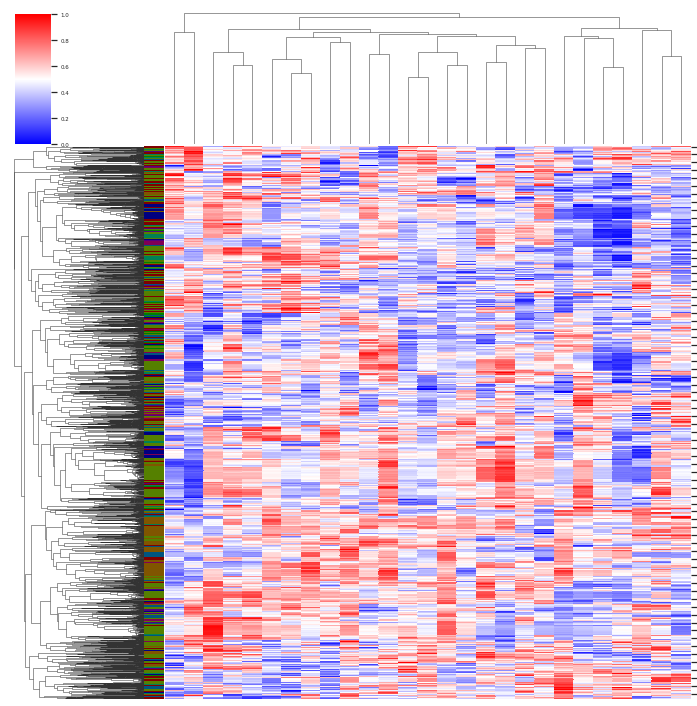

<Figure size 432x288 with 0 Axes>

In [9]:
DTCRU.HeatMap_Sequences()

We can see here that we've learned a feature space that is only 19 dimensions from the provided initial 256 to cover the data. This can be helpful for downstream analysis to reduce the computational burden. These dimensions also will tend to be more independent as we are encouraging the model to find the minimal number of dimensions to cover the data.

We can also plot the explained variance ratio (akin to PCA over all the dimensions) and the cumulative sum of the explained variance ratio as follows.

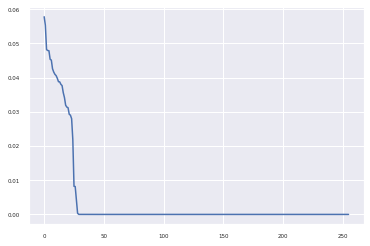

In [10]:
import matplotlib.pyplot as plt
plt.plot(DTCRU.explained_variance_ratio_)

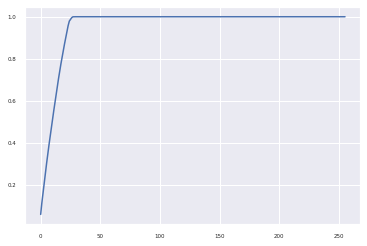

In [11]:
import numpy as np
plt.plot(np.cumsum(DTCRU.explained_variance_ratio_))

And thus we can see that most the latent dimensions were turned off and we only needed a subset to cover our data.
